# Exploratory Data Analysis - SQL Queries

SQL-based analysis using DuckDB to validate metrics reported in 01_eda_report.md.

In [1]:
import sys
from pathlib import Path

# Add src directory to path for importing DataLoader
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / 'src'))

from data_loader import DataLoader

# Standard imports
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("DuckDB version:", duckdb.__version__)
print("✓ DataLoader imported successfully")


DuckDB version: 1.4.3
✓ DataLoader imported successfully


In [2]:
# Run DataLoader to load and process raw data
print("="*70)
print("RUNNING DATA LOADER")
print("="*70)

loader = DataLoader(
    raw_data_path="test_data",
    processed_data_path="data/processed"
)

# Load all datasets
datasets = loader.load_all()

print(f"\n{'='*70}")
print("LOADED DATASETS")
print(f"{'='*70}")
for name, df in datasets.items():
    print(f"{name:20s}: {len(df):,} rows, {len(df.columns)} columns")

# Save processed data
loader.save_processed(datasets)

print(f"\n{'='*70}")
print("✓ Data saved to: {loader.processed_data_path}")
print(f"{'='*70}")


RUNNING DATA LOADER
[WARN] training_content: nulls detected -> {'categories': 25}
[WARN] testing_content: nulls detected -> {'categories': 3}

LOADED DATASETS
devices             : 10,400 rows, 11 columns
events              : 3,544,161 rows, 13 columns
training_content    : 8,170 rows, 12 columns
testing_content     : 970 rows, 12 columns

✓ Data saved to: {loader.processed_data_path}


## 1. Load Data

In [3]:
conn = duckdb.connect(':memory:')

project_root = Path.cwd().parent
data_dir = project_root / 'data' / 'processed'

conn.execute(f"""
    CREATE TABLE devices AS 
    SELECT * FROM read_csv_auto('{data_dir}/devices.csv')
""")

conn.execute(f"""
    CREATE TABLE events AS 
    SELECT * FROM read_csv_auto('{data_dir}/events.csv')
""")

conn.execute(f"""
    CREATE TABLE training_content AS 
    SELECT * FROM read_csv_auto('{data_dir}/training_content.csv')
""")

conn.execute(f"""
    CREATE TABLE testing_content AS 
    SELECT * FROM read_csv_auto('{data_dir}/testing_content.csv')
""")

print("Tables loaded successfully")

Tables loaded successfully


In [4]:
query = """
SELECT 
    'devices' as table_name,
    COUNT(*) as row_count,
    COUNT(DISTINCT deviceid) as unique_devices
FROM devices

UNION ALL

SELECT 
    'events' as table_name,
    COUNT(*) as row_count,
    COUNT(DISTINCT deviceId) as unique_users
FROM events

UNION ALL

SELECT 
    'training_content' as table_name,
    COUNT(*) as row_count,
    COUNT(DISTINCT hashid) as unique_articles
FROM training_content

UNION ALL

SELECT 
    'testing_content' as table_name,
    COUNT(*) as row_count,
    COUNT(DISTINCT hashid) as unique_articles
FROM testing_content;
"""

result = conn.execute(query).fetchdf()
print("Dataset Overview:")
print(result)

Dataset Overview:
         table_name  row_count  unique_devices
0           devices      10400           10400
1            events    3544161            8977
2  training_content       8170            8168
3   testing_content        970             970


## 2. Data Quality

In [5]:
query = """
SELECT
    COUNT(*) as total_devices,
    COUNT(DISTINCT deviceid) as unique_devices,
    COUNT(deviceid) - COUNT(DISTINCT deviceid) as duplicate_devices,
    COUNT(*) - COUNT(platform) as missing_platform,
    COUNT(*) - COUNT(language_selected) as missing_language,
    COUNT(*) - COUNT(district) as missing_district,
    COUNT(*) - COUNT(lastknownsubadminarea) as missing_city,
    ROUND(100.0 * COUNT(district) / COUNT(*), 2) as district_completeness_pct
FROM devices;
"""

result = conn.execute(query).fetchdf()
print("Devices Table - Data Quality:")
print(result.T)

Devices Table - Data Quality:
                                 0
total_devices              10400.0
unique_devices             10400.0
duplicate_devices              0.0
missing_platform               0.0
missing_language               0.0
missing_district           10379.0
missing_city                 908.0
district_completeness_pct      0.2


In [6]:
query = """
SELECT
    COUNT(*) as total_events,
    COUNT(DISTINCT deviceId) as unique_users,
    COUNT(DISTINCT hashId) as unique_articles,
    COUNT(DISTINCT event_type) as unique_event_types,
    COUNT(*) - COUNT(overallTimeSpent) as missing_time_spent,
    COUNT(*) - COUNT(cardViewPosition) as missing_position,
    ROUND(100.0 * COUNT(overallTimeSpent) / COUNT(*), 2) as time_spent_completeness_pct
FROM events;
"""

result = conn.execute(query).fetchdf()
print("Events Table - Data Quality:")
print(result.T)

Events Table - Data Quality:
                                      0
total_events                 3544161.00
unique_users                    8977.00
unique_articles                14623.00
unique_event_types                 7.00
missing_time_spent              1123.00
missing_position                1123.00
time_spent_completeness_pct       99.97


In [7]:
query = """
SELECT
    'training_content' as dataset,
    COUNT(*) as total_articles,
    COUNT(DISTINCT hashid) as unique_articles,
    COUNT(*) - COUNT(categories) as missing_categories,
    COUNT(*) - COUNT(newsLanguage) as missing_language,
    COUNT(*) - COUNT(hashtags) as missing_hashtags,
    ROUND(100.0 * COUNT(categories) / COUNT(*), 2) as categories_completeness_pct
FROM training_content

UNION ALL

SELECT
    'testing_content' as dataset,
    COUNT(*) as total_articles,
    COUNT(DISTINCT hashid) as unique_articles,
    COUNT(*) - COUNT(categories) as missing_categories,
    COUNT(*) - COUNT(newsLanguage) as missing_language,
    COUNT(*) - COUNT(hashtags) as missing_hashtags,
    ROUND(100.0 * COUNT(categories) / COUNT(*), 2) as categories_completeness_pct
FROM testing_content;
"""

result = conn.execute(query).fetchdf()
print("Content Tables - Data Quality:")
print(result)

Content Tables - Data Quality:
            dataset  total_articles  unique_articles  missing_categories  \
0  training_content            8170             8168                  25   
1   testing_content             970              970                   3   

   missing_language  missing_hashtags  categories_completeness_pct  
0                 0              6915                        99.69  
1                 0               933                        99.69  


## 3. User Segmentation

Platform Distribution:
  platform  user_count  percentage
0  ANDROID       10400       100.0


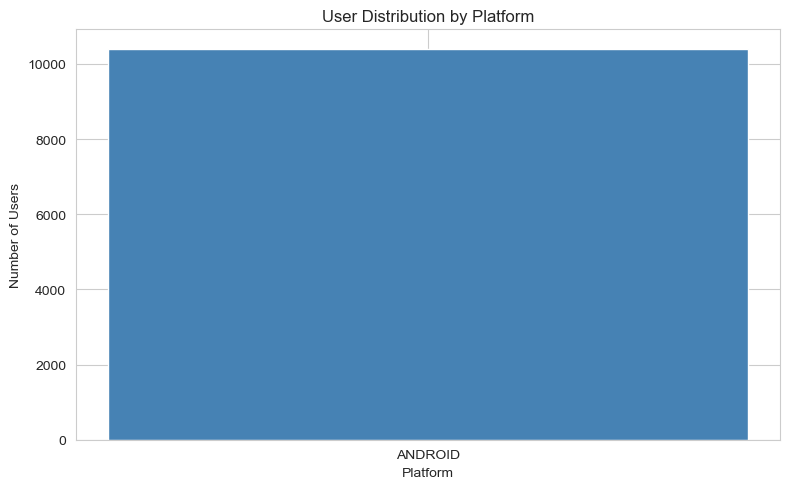

In [8]:
query = """
SELECT 
    platform,
    COUNT(*) as user_count,
    ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (), 2) as percentage
FROM devices
WHERE platform IS NOT NULL
GROUP BY platform
ORDER BY user_count DESC;
"""

result = conn.execute(query).fetchdf()
print("Platform Distribution:")
print(result)

plt.figure(figsize=(8, 5))
plt.bar(result['platform'], result['user_count'], color='steelblue')
plt.title('User Distribution by Platform')
plt.xlabel('Platform')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()

Top 10 Language Preferences:
  language_selected  user_count  percentage
0                en       10400       100.0


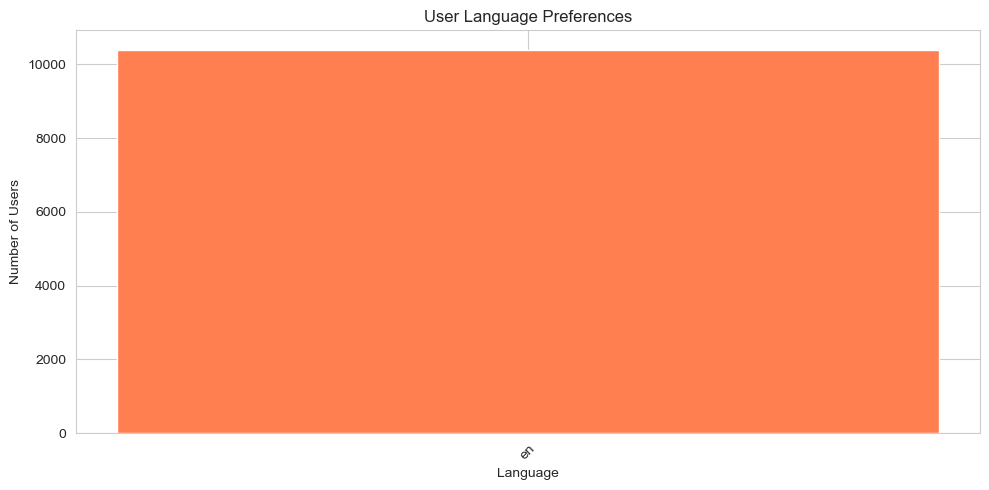

In [9]:
query = """
SELECT 
    language_selected,
    COUNT(*) as user_count,
    ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (), 2) as percentage
FROM devices
WHERE language_selected IS NOT NULL
GROUP BY language_selected
ORDER BY user_count DESC
LIMIT 10;
"""

result = conn.execute(query).fetchdf()
print("Top 10 Language Preferences:")
print(result)

plt.figure(figsize=(10, 5))
plt.bar(result['language_selected'], result['user_count'], color='coral')
plt.title('User Language Preferences')
plt.xlabel('Language')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
query = """
WITH user_activity AS (
    SELECT 
        deviceId,
        COUNT(*) as event_count,
        COUNT(DISTINCT hashId) as unique_articles_viewed,
        COUNT(DISTINCT event_type) as interaction_types,
        MIN(eventTimestamp) as first_activity,
        MAX(eventTimestamp) as last_activity
    FROM events
    GROUP BY deviceId
)
SELECT 
    CASE 
        WHEN event_count >= 1000 THEN 'Power User (1000+)'
        WHEN event_count >= 100 THEN 'Very Active (100-999)'
        WHEN event_count >= 10 THEN 'Active (10-99)'
        ELSE 'Passive (<10)'
    END as user_segment,
    COUNT(*) as user_count,
    ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (), 2) as percentage,
    ROUND(AVG(event_count), 2) as avg_events,
    ROUND(AVG(unique_articles_viewed), 2) as avg_articles,
    MIN(event_count) as min_events,
    MAX(event_count) as max_events
FROM user_activity
GROUP BY user_segment
ORDER BY avg_events DESC;
"""

segments = conn.execute(query).fetchdf()
print("User Segmentation by Activity Level:")
print(segments)

User Segmentation by Activity Level:
            user_segment  user_count  percentage  avg_events  avg_articles  \
0     Power User (1000+)         788        8.78     3186.25       2490.12   
1  Very Active (100-999)        2787       31.05      318.47        250.05   
2         Active (10-99)        3349       37.31       41.08         30.19   
3          Passive (<10)        2053       22.87        4.01          2.90   

   min_events  max_events  
0        1002       21363  
1         100         998  
2          10          99  
3           1           9  


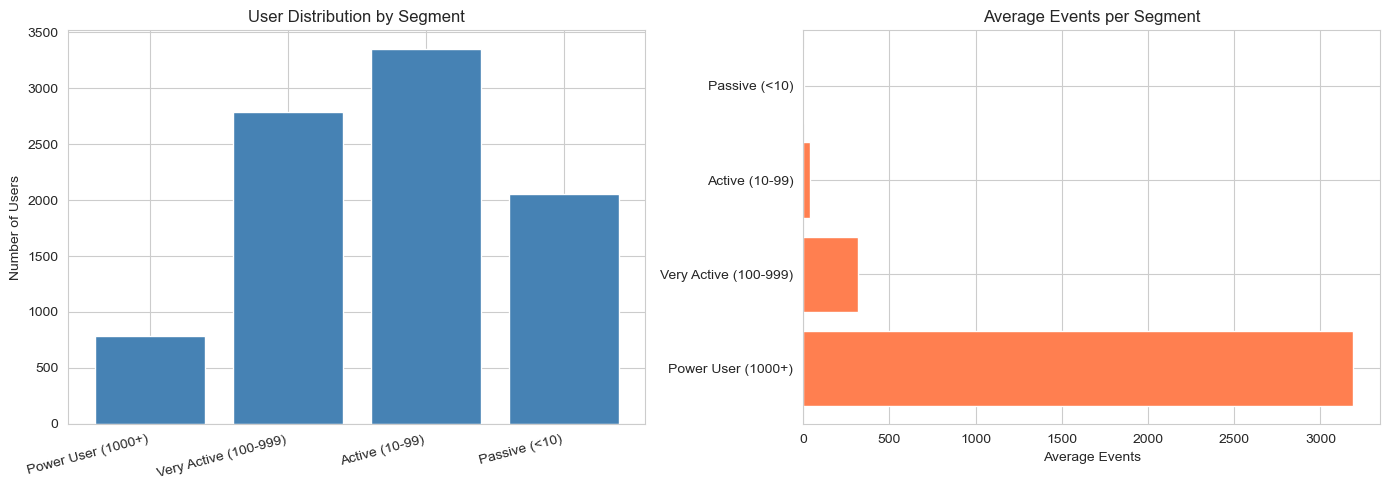

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(range(len(segments)), segments['user_count'], color='steelblue')
axes[0].set_xticks(range(len(segments)))
axes[0].set_xticklabels(segments['user_segment'], rotation=15, ha='right')
axes[0].set_title('User Distribution by Segment')
axes[0].set_ylabel('Number of Users')

axes[1].barh(range(len(segments)), segments['avg_events'], color='coral')
axes[1].set_yticks(range(len(segments)))
axes[1].set_yticklabels(segments['user_segment'])
axes[1].set_title('Average Events per Segment')
axes[1].set_xlabel('Average Events')

plt.tight_layout()
plt.show()

## 4. Event Distribution

In [12]:
query = """
SELECT 
    event_type,
    COUNT(*) as event_count,
    COUNT(DISTINCT deviceId) as unique_users,
    COUNT(DISTINCT hashId) as unique_articles,
    ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (), 2) as percentage_of_total
FROM events
GROUP BY event_type
ORDER BY event_count DESC;
"""

event_dist = conn.execute(query).fetchdf()
print("Event Type Distribution:")
print(event_dist)

Event Type Distribution:
                  event_type  event_count  unique_users  unique_articles  \
0            TimeSpent-Front      3480131          8976            14620   
1             TimeSpent-Back        44933          4853             5798   
2            News Bookmarked        10870          2073             4942   
3                News Shared         3517          1031             1636   
4          News Unbookmarked         2275           904             1437   
5  Relevancy Option Selected         1312           126              120   
6                     Search         1123           418                1   

   percentage_of_total  
0                98.19  
1                 1.27  
2                 0.31  
3                 0.10  
4                 0.06  
5                 0.04  
6                 0.03  


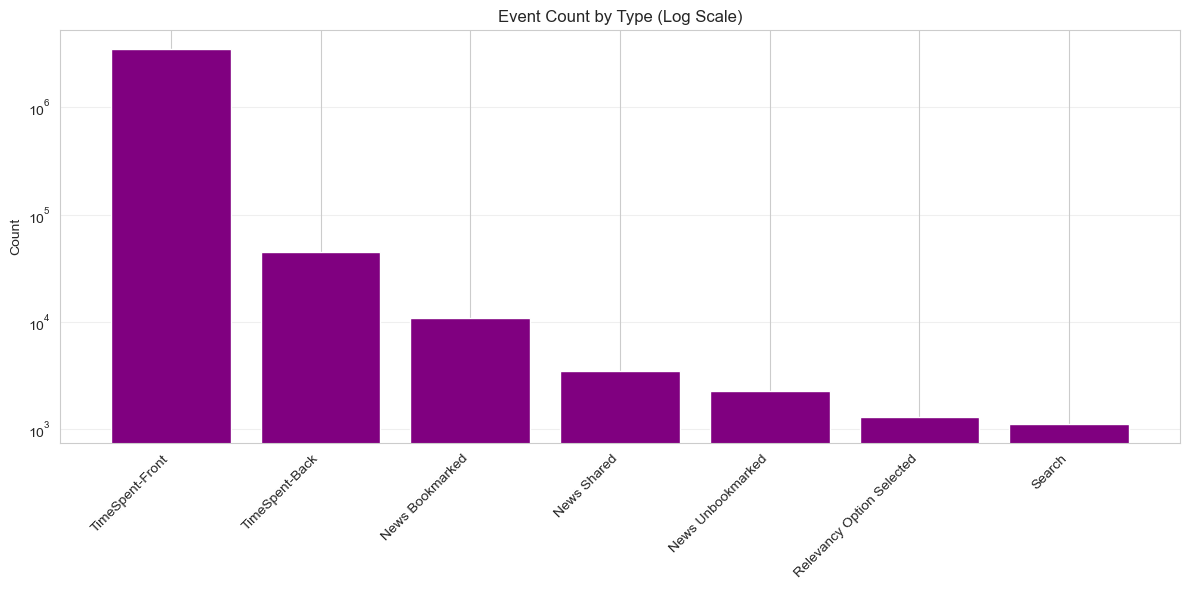


Event Type Statistics:
               event_type  event_count  unique_users  unique_articles  percentage_of_total
          TimeSpent-Front      3480131          8976            14620                98.19
           TimeSpent-Back        44933          4853             5798                 1.27
          News Bookmarked        10870          2073             4942                 0.31
              News Shared         3517          1031             1636                 0.10
        News Unbookmarked         2275           904             1437                 0.06
Relevancy Option Selected         1312           126              120                 0.04
                   Search         1123           418                1                 0.03


In [13]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(range(len(event_dist)), event_dist['event_count'], color='purple')
ax.set_xticks(range(len(event_dist)))
ax.set_xticklabels(event_dist['event_type'], rotation=45, ha='right')
ax.set_title('Event Count by Type (Log Scale)')
ax.set_ylabel('Count')
ax.set_yscale('log')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Display the data
print("\nEvent Type Statistics:")
print(event_dist.to_string(index=False))

In [14]:
query = """
WITH time_stats AS (
    SELECT 
        TRY_CAST(overallTimeSpent AS DOUBLE) as time_spent
    FROM events
    WHERE overallTimeSpent IS NOT NULL
      AND event_type IN ('TimeSpent-Front', 'TimeSpent-Back')
)
SELECT
    COUNT(*) as total_records,
    ROUND(AVG(time_spent), 2) as mean,
    ROUND(MEDIAN(time_spent), 2) as median,
    ROUND(STDDEV(time_spent), 2) as std_dev,
    MIN(time_spent) as min,
    MAX(time_spent) as max,
    ROUND(PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY time_spent), 2) as q25,
    ROUND(PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY time_spent), 2) as q75,
    ROUND(PERCENTILE_CONT(0.95) WITHIN GROUP (ORDER BY time_spent), 2) as q95,
    ROUND(PERCENTILE_CONT(0.99) WITHIN GROUP (ORDER BY time_spent), 2) as q99
FROM time_stats;
"""

result = conn.execute(query).fetchdf()
print("Time Spent Statistics (seconds):")
print(result.T)

Time Spent Statistics (seconds):
                        0
total_records  3525064.00
mean                 9.01
median               3.78
std_dev             55.05
min                  0.00
max              41047.59
q25                  1.22
q75                  9.31
q95                 32.28
q99                 63.31


## 5. Content Analysis

In [15]:
query = """
SELECT 
    newsType,
    newsLanguage,
    COUNT(*) as article_count,
    ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (), 2) as percentage
FROM training_content
WHERE newsType IS NOT NULL AND newsLanguage IS NOT NULL
GROUP BY newsType, newsLanguage
ORDER BY article_count DESC
LIMIT 15;
"""

result = conn.execute(query).fetchdf()
print("Training Content - Type and Language Distribution:")
print(result)

Training Content - Type and Language Distribution:
                                             newsType newsLanguage  \
0                                                NEWS      english   
1                                                NEWS        hindi   
2                                                 nan      english   
3                                          VIDEO_NEWS      english   
4                                                 nan          nan   
5                                            politics          nan   
6                                                NEWS     gujarati   
7                                          technology          nan   
8                              it has been six months          nan   
9                                           national"          nan   
10                                      entertainment          nan   
11                             entertainment,national          nan   
12                             your pel

In [16]:
query = """
WITH category_split AS (
    SELECT 
        TRIM(unnest(string_split(categories, ','))) as category
    FROM training_content
    WHERE categories IS NOT NULL AND categories != ''
)
SELECT 
    category,
    COUNT(*) as article_count,
    ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (), 2) as percentage
FROM category_split
WHERE category != ''
GROUP BY category
ORDER BY article_count DESC
LIMIT 20;
"""

categories = conn.execute(query).fetchdf()
print("Top 20 Content Categories:")
print(categories)

Top 20 Content Categories:
                   category  article_count  percentage
0                  national           3574       35.51
1                     world           1498       14.88
2                    sports           1024       10.17
3                  business            939        9.33
4                  politics            618        6.14
5             entertainment            553        5.49
6                technology            420        4.17
7                   science            217        2.16
8                   startup            196        1.95
9                VIDEO_NEWS            165        1.64
10            miscellaneous            151        1.50
11  Russia-Ukraine_Conflict            147        1.46
12           Wimbledon_2023            128        1.27
13               Ashes_2023             78        0.78
14                education             61        0.61
15                   travel             51        0.51
16               automobile           

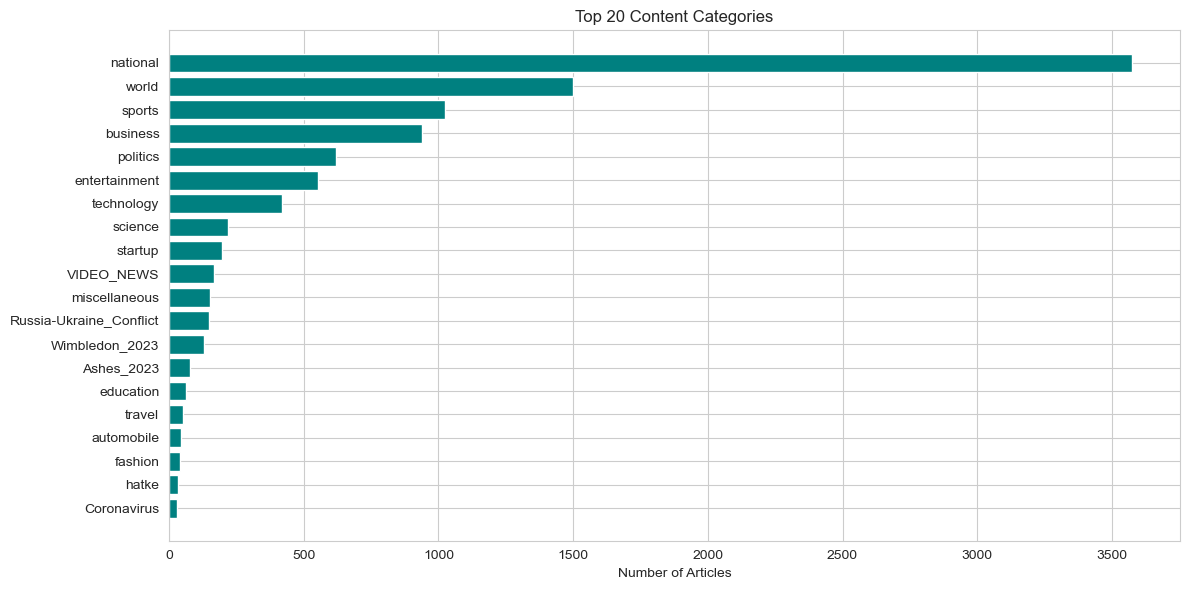

In [17]:
plt.figure(figsize=(12, 6))
plt.barh(range(len(categories)), categories['article_count'], color='teal')
plt.yticks(range(len(categories)), categories['category'])
plt.xlabel('Number of Articles')
plt.title('Top 20 Content Categories')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 6. Engagement Scoring

In [18]:
query = """
WITH engagement_scores AS (
    SELECT 
        deviceId,
        hashId,
        SUM(TRY_CAST(overallTimeSpent AS DOUBLE)) as total_time_spent,
        SUM(CASE 
            WHEN event_type = 'News Shared' THEN 5.0
            WHEN event_type = 'News Bookmarked' THEN 3.0
            WHEN event_type = 'TimeSpent-Back' THEN 2.0
            WHEN event_type = 'TimeSpent-Front' THEN 1.0
            ELSE 0.0
        END) as engagement_score,
        COUNT(DISTINCT event_type) as interaction_types
    FROM events
    WHERE event_type IN ('TimeSpent-Front', 'TimeSpent-Back', 
                         'News Bookmarked', 'News Shared')
    GROUP BY deviceId, hashId
)
SELECT 
    deviceId,
    COUNT(*) as articles_engaged,
    ROUND(AVG(engagement_score), 2) as avg_engagement_score,
    ROUND(SUM(total_time_spent), 2) as total_time_spent_sec,
    ROUND(MAX(engagement_score), 2) as max_engagement_score,
    ROUND(AVG(interaction_types), 2) as avg_interaction_types
FROM engagement_scores
GROUP BY deviceId
ORDER BY avg_engagement_score DESC
LIMIT 20;
"""

result = conn.execute(query).fetchdf()
print("Top 20 Users by Engagement Score:")
print(result)

Top 20 Users by Engagement Score:
                                deviceId  articles_engaged  \
0   d3ca1935-10f7-4ba5-9e67-12c2c83085ab                 3   
1   968e193d-52d8-4ba6-b788-5e6bda6387cd                 3   
2   df4992e2-38d7-42e2-8007-bbd5aabf3b97                 1   
3   c9498d86-6a0e-47c6-946b-b8ef1cc40b92                 1   
4   b7a72675-bd91-46ee-8035-ff94eff86174                 1   
5   a3e738ea-4889-4f77-b2ff-68e35a088279                 1   
6   42b783e6-89c5-4e8a-8ca1-a0eb196b5644                 1   
7   f6aded33-5c96-4c1f-8d4a-faaa3713507e                 8   
8   556c9a67-7d6f-465c-9e0b-0c7dc4cd1b73                 1   
9   633c7deb-d5a2-49e1-b9e9-332bf257d397                 2   
10  80fe1b45-2033-4ef6-80bc-5f6af5db0410                 1   
11  8f5d5a5e-21cc-4b8e-87b1-0542bad56c02                 3   
12  3f51b728-7408-4107-893e-2df0d5082813                 1   
13  776dcb25-83c9-4f2b-a25b-913e8ed86cdb                 1   
14  fcd78819-ac23-48c1-a3db-33bf767c

## 7. Content Popularity

In [19]:
query = """
WITH content_stats AS (
    SELECT 
        e.hashId,
        COUNT(DISTINCT e.deviceId) as unique_users,
        COUNT(*) as total_interactions,
        ROUND(AVG(TRY_CAST(e.overallTimeSpent AS DOUBLE)), 2) as avg_time_spent,
        SUM(CASE WHEN e.event_type = 'News Bookmarked' THEN 1 ELSE 0 END) as bookmark_count,
        SUM(CASE WHEN e.event_type = 'News Shared' THEN 1 ELSE 0 END) as share_count,
        SUM(CASE WHEN e.event_type = 'TimeSpent-Back' THEN 1 ELSE 0 END) as full_read_count,
        SUM(CASE WHEN e.event_type = 'TimeSpent-Front' THEN 1 ELSE 0 END) as summary_view_count
    FROM events e
    WHERE e.event_type IN ('TimeSpent-Front', 'TimeSpent-Back', 
                           'News Bookmarked', 'News Shared')
    GROUP BY e.hashId
)
SELECT 
    cs.hashId,
    SUBSTRING(c.title, 1, 60) || '...' as title_preview,
    c.newsType,
    c.newsLanguage,
    cs.unique_users,
    cs.total_interactions,
    cs.avg_time_spent,
    cs.bookmark_count,
    cs.share_count,
    cs.full_read_count,
    ROUND(CAST(cs.share_count AS DOUBLE) / NULLIF(cs.unique_users, 0) * 100, 2) as virality_pct,
    ROUND(CAST(cs.full_read_count AS DOUBLE) / NULLIF(cs.summary_view_count, 0) * 100, 2) as ctr_pct
FROM content_stats cs
INNER JOIN training_content c ON cs.hashId = c.hashid
WHERE cs.unique_users >= 100
ORDER BY cs.unique_users DESC
LIMIT 20;
"""

popular_content = conn.execute(query).fetchdf()
print("Top 20 Most Popular Articles:")
print(popular_content)

Top 20 Most Popular Articles:
        hashId                                      title_preview newsType  \
0   q4dqaz8m-1  MakeMyTrip launches Rocky & Rani-inspired roma...     NEWS   
1   im5bxn3a-1  Bookings open for Honda Elevate in India, laun...     NEWS   
2   4hvxw5is-1  Pantaloons 'SOS' is back with minimum 30%* off...     NEWS   
3   7q98ag4y-1  Assured internship with Gaming & Esports certi...     NEWS   
4   i2auabwt-1  Message privately with multiple layers of prot...     NEWS   
5   eiwfp6n0-1  Dull & ageing skin? Here's the latest innovati...     NEWS   
6   sbmzc4jw-1  Redmi 12  with flagship design to launch in In...     NEWS   
7   a0osrswc-1  Healthy Lifestyle starts with picking the righ...     NEWS   
8   gnymk27p-1  Skincare formulated in France with Natural Bio...     NEWS   
9   ejv9vgry-1  Award-winning Dr. Soni suggests Minoxidil-Free...     NEWS   
10  wip65zgj-1  L’Oréal launches new iNOA, a no ammonia hair c...     NEWS   
11  osjythnx-1  Conductor caught h

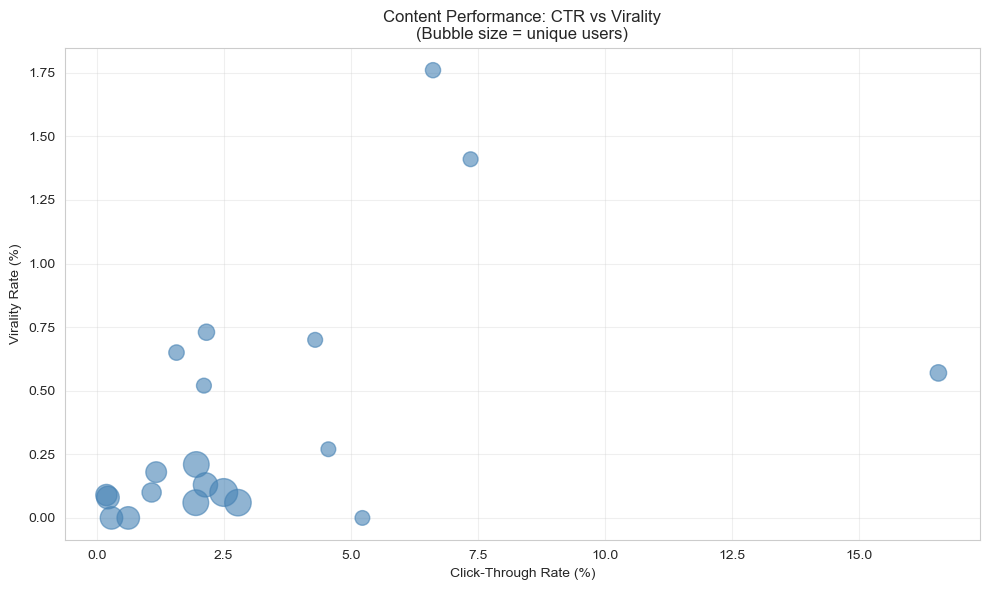

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(popular_content['ctr_pct'], popular_content['virality_pct'], 
           s=popular_content['unique_users']/10, alpha=0.6, c='steelblue')
plt.xlabel('Click-Through Rate (%)')
plt.ylabel('Virality Rate (%)')
plt.title('Content Performance: CTR vs Virality\n(Bubble size = unique users)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Geographic Preferences

In [21]:
query = """
SELECT 
    COALESCE(d.lastknownsubadminarea, 'Unknown') as city,
    COUNT(DISTINCT e.deviceId) as unique_users,
    COUNT(*) as total_events,
    ROUND(AVG(TRY_CAST(e.overallTimeSpent AS DOUBLE)), 2) as avg_time_spent
FROM events e
INNER JOIN devices d ON e.deviceId = d.deviceid
WHERE d.lastknownsubadminarea IS NOT NULL AND d.lastknownsubadminarea != ''
GROUP BY d.lastknownsubadminarea
HAVING COUNT(DISTINCT e.deviceId) >= 10
ORDER BY unique_users DESC
LIMIT 15;
"""

geo_dist = conn.execute(query).fetchdf()
print("Top 15 Cities by User Activity:")
print(geo_dist)

Top 15 Cities by User Activity:
         city  unique_users  total_events  avg_time_spent
0      Mumbai            41          6061            7.46
1       Delhi            34          3433            9.37
2   Bengaluru            31          3340           11.50
3     Kolkata            23          2798           10.41
4       Noida            21          4259            7.88
5       Patna            19          1107           18.24
6     Lucknow            15          1482            9.60
7     Gurgaon            15          1249           14.31
8     Chennai            14         10677            5.94
9   Hyderabad            13          3524            6.94
10  Faridabad            12           317            6.12
11     Indore            11          1003           10.42
12       Pune            10          4622           12.62
13  New Delhi            10           824            7.22


In [22]:
query = """
WITH category_split AS (
    SELECT 
        e.deviceId,
        d.lastknownsubadminarea as city,
        TRIM(unnest(string_split(c.categories, ','))) as category,
        TRY_CAST(e.overallTimeSpent AS DOUBLE) as time_spent
    FROM events e
    INNER JOIN devices d ON e.deviceId = d.deviceid
    INNER JOIN training_content c ON e.hashId = c.hashid
    WHERE d.lastknownsubadminarea IS NOT NULL 
      AND d.lastknownsubadminarea != ''
      AND c.categories IS NOT NULL
      AND e.event_type = 'TimeSpent-Front'
)
SELECT 
    city,
    category,
    COUNT(DISTINCT deviceId) as unique_users,
    COUNT(*) as interaction_count,
    ROUND(AVG(time_spent), 2) as avg_time_spent
FROM category_split
WHERE category != ''
GROUP BY city, category
HAVING COUNT(DISTINCT deviceId) >= 3
ORDER BY city, interaction_count DESC;
"""

geo_preferences = conn.execute(query).fetchdf()
print(f"City-wise Category Preferences (showing first 30 of {len(geo_preferences)} rows):")
print(geo_preferences.head(30))

City-wise Category Preferences (showing first 30 of 415 rows):
          city       category  unique_users  interaction_count  avg_time_spent
0         Agra       national             6                116           17.27
1         Agra          world             4                 42           10.00
2         Agra       politics             3                 14           26.94
3         Agra     technology             3                 12           24.10
4    Ahmedabad       national             8                313            3.35
5    Ahmedabad          world             4                175            1.86
6    Ahmedabad       business             4                162            2.29
7    Ahmedabad         sports             6                115            1.42
8    Ahmedabad        science             4                 97            2.02
9    Ahmedabad     technology             4                 88            2.13
10   Ahmedabad        startup             3                 68      

## 9. Category Affinity

In [23]:
query = """
WITH category_split AS (
    SELECT 
        e.deviceId,
        TRIM(unnest(string_split(c.categories, ','))) as category,
        e.event_type,
        TRY_CAST(e.overallTimeSpent AS DOUBLE) as time_spent
    FROM events e
    INNER JOIN training_content c ON e.hashId = c.hashid
    WHERE c.categories IS NOT NULL 
      AND c.categories != ''
      AND e.event_type IN ('TimeSpent-Front', 'News Bookmarked', 'News Shared')
),
user_category_interactions AS (
    SELECT 
        deviceId,
        category,
        COUNT(*) as view_count,
        SUM(time_spent) as total_time_spent,
        SUM(CASE WHEN event_type = 'News Bookmarked' THEN 1 ELSE 0 END) as bookmarks,
        SUM(CASE WHEN event_type = 'News Shared' THEN 1 ELSE 0 END) as shares
    FROM category_split
    WHERE category != ''
    GROUP BY deviceId, category
),
user_totals AS (
    SELECT 
        deviceId,
        SUM(view_count) as total_views
    FROM user_category_interactions
    GROUP BY deviceId
)
SELECT 
    uci.deviceId,
    uci.category,
    uci.view_count,
    ROUND(uci.view_count * 100.0 / ut.total_views, 2) as percentage_of_views,
    ROUND(COALESCE(uci.total_time_spent, 0), 2) as total_time,
    uci.bookmarks,
    uci.shares,
    ROUND(
        (uci.view_count * 1.0) + 
        (uci.bookmarks * 3.0) + 
        (uci.shares * 5.0) +
        (COALESCE(uci.total_time_spent, 0) * 0.1)
    , 2) as affinity_score
FROM user_category_interactions uci
INNER JOIN user_totals ut ON uci.deviceId = ut.deviceId
WHERE ut.total_views >= 20
ORDER BY uci.deviceId, affinity_score DESC;
"""

user_affinities = conn.execute(query).fetchdf()
print(f"User Category Affinity (showing first 50 of {len(user_affinities)} rows):")
print(user_affinities.head(50))

User Category Affinity (showing first 50 of 80679 rows):
                                deviceId                   category  \
0   0002d448-f398-44d8-8806-df93d1dc770b                   national   
1   0002d448-f398-44d8-8806-df93d1dc770b                      world   
2   0002d448-f398-44d8-8806-df93d1dc770b                     sports   
3   0002d448-f398-44d8-8806-df93d1dc770b                   business   
4   0002d448-f398-44d8-8806-df93d1dc770b              entertainment   
5   0002d448-f398-44d8-8806-df93d1dc770b                   politics   
6   0002d448-f398-44d8-8806-df93d1dc770b                 technology   
7   0002d448-f398-44d8-8806-df93d1dc770b                    startup   
8   0002d448-f398-44d8-8806-df93d1dc770b              miscellaneous   
9   0002d448-f398-44d8-8806-df93d1dc770b                    science   
10  0002d448-f398-44d8-8806-df93d1dc770b    Russia-Ukraine_Conflict   
11  0002d448-f398-44d8-8806-df93d1dc770b                     travel   
12  0002d448-f398-44

Top 10 Category Preferences for Sample User: 0002d448-f398-44d8-8806-df93d1dc770b
        category  view_count  percentage_of_views  affinity_score
0       national          52                23.96           89.31
1          world          38                17.51           59.30
2         sports          27                12.44           47.59
3       business          28                12.90           44.56
4  entertainment          15                 6.91           24.47
5       politics          12                 5.53           24.22
6     technology          11                 5.07           21.18
7        startup          10                 4.61           15.13
8  miscellaneous           6                 2.76            9.43
9        science           5                 2.30            8.80


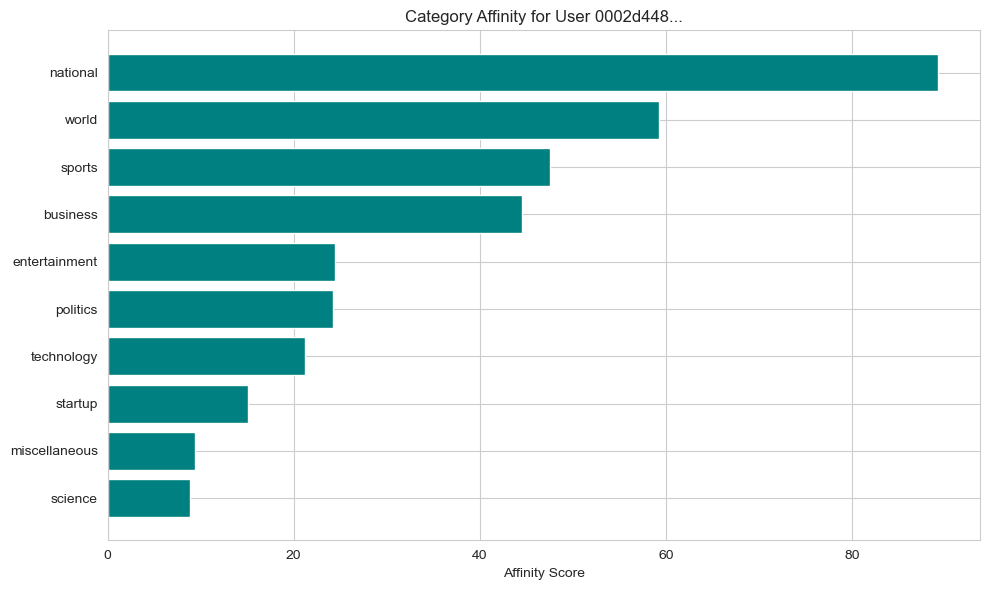

In [24]:
sample_user = user_affinities.iloc[0]['deviceId']
user_prefs = user_affinities[user_affinities['deviceId'] == sample_user].head(10)

print(f"Top 10 Category Preferences for Sample User: {sample_user}")
print(user_prefs[['category', 'view_count', 'percentage_of_views', 'affinity_score']])

plt.figure(figsize=(10, 6))
plt.barh(range(len(user_prefs)), user_prefs['affinity_score'], color='teal')
plt.yticks(range(len(user_prefs)), user_prefs['category'])
plt.xlabel('Affinity Score')
plt.title(f'Category Affinity for User {sample_user[:8]}...')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 10. Matrix Sparsity

In [25]:
query = """
WITH stats AS (
    SELECT 
        COUNT(DISTINCT deviceId) as unique_users,
        COUNT(DISTINCT hashId) as unique_items,
        COUNT(*) as interactions
    FROM events
)
SELECT 
    unique_users,
    unique_items,
    interactions,
    unique_users * unique_items as possible_interactions,
    ROUND(100.0 * (1 - CAST(interactions AS DOUBLE) / (unique_users * unique_items)), 4) as sparsity_pct,
    ROUND(CAST(interactions AS DOUBLE) / unique_users, 2) as avg_interactions_per_user,
    ROUND(CAST(interactions AS DOUBLE) / unique_items, 2) as avg_interactions_per_item
FROM stats;
"""

sparsity = conn.execute(query).fetchdf()
print("User-Item Matrix Sparsity Analysis:")
print(sparsity.T)

User-Item Matrix Sparsity Analysis:
                                      0
unique_users               8.977000e+03
unique_items               1.462300e+04
interactions               3.544161e+06
possible_interactions      1.312707e+08
sparsity_pct               9.730010e+01
avg_interactions_per_user  3.948000e+02
avg_interactions_per_item  2.423700e+02


## 11. Cold Start Analysis

In [26]:
query = """
SELECT 
    'Training Articles' as dataset,
    COUNT(DISTINCT hashid) as article_count,
    COUNT(DISTINCT newsType) as unique_types,
    COUNT(DISTINCT newsLanguage) as unique_languages
FROM training_content

UNION ALL

SELECT 
    'Testing Articles' as dataset,
    COUNT(DISTINCT hashid) as article_count,
    COUNT(DISTINCT newsType) as unique_types,
    COUNT(DISTINCT newsLanguage) as unique_languages
FROM testing_content

UNION ALL

SELECT 
    'Overlap (Data Leakage)' as dataset,
    COUNT(DISTINCT t.hashid) as article_count,
    NULL as unique_types,
    NULL as unique_languages
FROM testing_content t
INNER JOIN training_content tr ON t.hashid = tr.hashid;
"""

cold_start = conn.execute(query).fetchdf()
print("Training vs Testing Data Analysis:")
print(cold_start)

Training vs Testing Data Analysis:
                  dataset  article_count  unique_types  unique_languages
0       Training Articles           8168            21                 6
1        Testing Articles            970             6                 7
2  Overlap (Data Leakage)              0          <NA>              <NA>


In [27]:
query = """
WITH train_langs AS (
    SELECT 
        newsLanguage,
        COUNT(*) as count
    FROM training_content
    WHERE newsLanguage IS NOT NULL
    GROUP BY newsLanguage
),
test_langs AS (
    SELECT 
        newsLanguage,
        COUNT(*) as count
    FROM testing_content
    WHERE newsLanguage IS NOT NULL
    GROUP BY newsLanguage
)
SELECT 
    COALESCE(tr.newsLanguage, te.newsLanguage) as language,
    COALESCE(tr.count, 0) as training_count,
    COALESCE(te.count, 0) as testing_count
FROM train_langs tr
FULL OUTER JOIN test_langs te ON tr.newsLanguage = te.newsLanguage
ORDER BY training_count DESC, testing_count DESC;
"""

lang_comparison = conn.execute(query).fetchdf()
print("Language Distribution Comparison:")
print(lang_comparison)

Language Distribution Comparison:
   language  training_count  testing_count
0   english            6211            364
1     hindi            1845            371
2       nan             109              3
3  gujarati               3             61
4   Twitter               1              0
5       ANI               1              0
6    telugu               0             94
7   kannada               0             76
8      भाषा               0              1


/var/folders/_b/f8jj0h8j2nl4j1fggf33t1xm0000gn/T/ipykernel_26426/563614217.py:15: UserWarning: Glyph 2349 (\N{DEVANAGARI LETTER BHA}) missing from current font.
  plt.tight_layout()
/var/folders/_b/f8jj0h8j2nl4j1fggf33t1xm0000gn/T/ipykernel_26426/563614217.py:15: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout()
/var/folders/_b/f8jj0h8j2nl4j1fggf33t1xm0000gn/T/ipykernel_26426/563614217.py:15: UserWarning: Glyph 2366 (\N{DEVANAGARI VOWEL SIGN AA}) missing from current font.
  plt.tight_layout()
/var/folders/_b/f8jj0h8j2nl4j1fggf33t1xm0000gn/T/ipykernel_26426/563614217.py:15: UserWarning: Glyph 2359 (\N{DEVANAGARI LETTER SSA}) missing from current font.
  plt.tight_layout()
/Users/deepakkumarsingh/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 2349 (\N{DEVANAGARI LETTER BHA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/deepakkumarsingh/anaconda3/lib/python3.11/site-packag

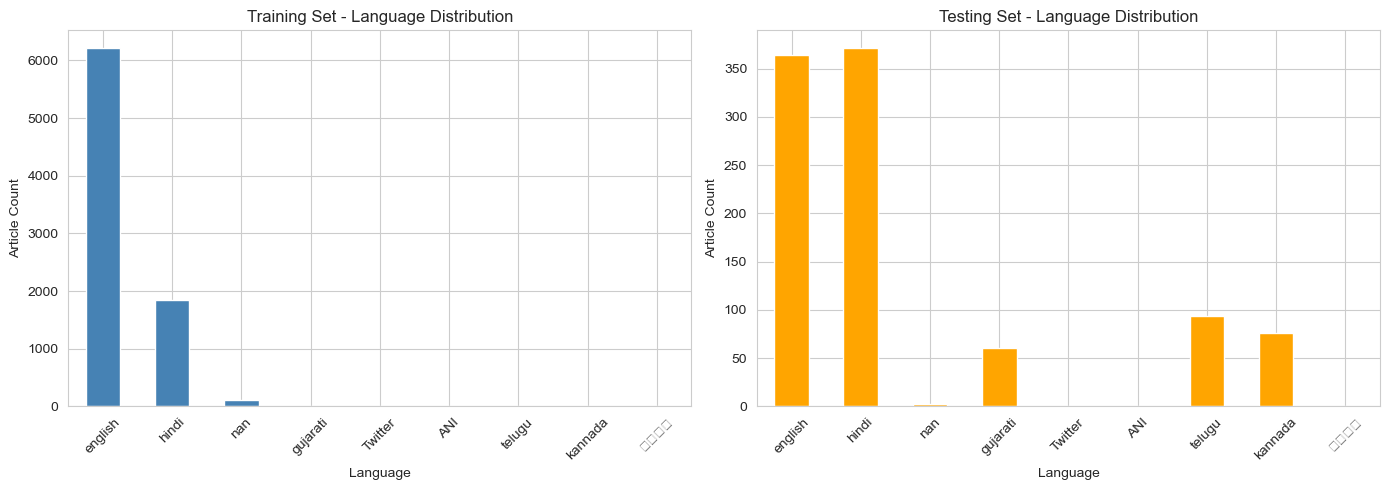

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

lang_comparison.plot(kind='bar', x='language', y='training_count', ax=axes[0], color='steelblue', legend=False)
axes[0].set_title('Training Set - Language Distribution')
axes[0].set_ylabel('Article Count')
axes[0].set_xlabel('Language')
axes[0].tick_params(axis='x', rotation=45)

lang_comparison.plot(kind='bar', x='language', y='testing_count', ax=axes[1], color='orange', legend=False)
axes[1].set_title('Testing Set - Language Distribution')
axes[1].set_ylabel('Article Count')
axes[1].set_xlabel('Language')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 12. Summary

In [29]:
query = """
WITH summary AS (
    SELECT
        (SELECT COUNT(DISTINCT deviceid) FROM devices) as total_users,
        (SELECT COUNT(*) FROM events) as total_events,
        (SELECT COUNT(DISTINCT hashid) FROM training_content) as training_articles,
        (SELECT COUNT(DISTINCT hashid) FROM testing_content) as testing_articles,
        (SELECT COUNT(DISTINCT deviceId) FROM events) as active_users,
        (SELECT COUNT(DISTINCT hashId) FROM events) as articles_with_interactions
)
SELECT 
    total_users,
    active_users,
    ROUND(100.0 * active_users / total_users, 2) as active_user_pct,
    total_events,
    ROUND(CAST(total_events AS DOUBLE) / active_users, 2) as avg_events_per_user,
    training_articles,
    testing_articles,
    articles_with_interactions,
    training_articles - articles_with_interactions as cold_start_articles
FROM summary;
"""

summary = conn.execute(query).fetchdf()
print("Dataset Summary Statistics:")
print(summary.T)

Dataset Summary Statistics:
                                     0
total_users                   10400.00
active_users                   8977.00
active_user_pct                  86.32
total_events                3544161.00
avg_events_per_user             394.80
training_articles              8168.00
testing_articles                970.00
articles_with_interactions    14623.00
cold_start_articles           -6455.00


In [30]:
print("=" * 80)
print("KEY INSIGHTS")
print("=" * 80)

sparsity_value = sparsity.iloc[0]['sparsity_pct']
print(f"\n1. Matrix Sparsity: {sparsity_value:.2f}%")
print(f"   → Hybrid approach needed (collaborative + content-based)")

print(f"\n2. User Segments:")
for _, row in segments.iterrows():
    print(f"   {row['user_segment']}: {row['percentage']}%")

dominant_event = event_dist.iloc[0]
print(f"\n3. Dominant Signal: {dominant_event['event_type']} ({dominant_event['percentage_of_total']:.1f}%)")

testing_count = cold_start.iloc[1]['article_count']
print(f"\n4. Cold Start: {testing_count} new articles with zero history")

top_category = categories.iloc[0]
print(f"\n5. Top Category: {top_category['category']} ({top_category['percentage']}%)")

print(f"\n{'='*80}")
print("See 01_eda_report.md for complete analysis")
print("="*80)

KEY INSIGHTS FOR RECOMMENDATION STRATEGY

1. SPARSITY CHALLENGE
   Matrix sparsity: 97.30%
   Implication: Need hybrid approach combining collaborative and content-based filtering

2. USER SEGMENTATION
   Power User (1000+): 788 users (8.78%)
   Very Active (100-999): 2787 users (31.05%)
   Active (10-99): 3349 users (37.31%)
   Passive (<10): 2053 users (22.87%)
   Implication: Different recommendation strategies per segment

3. DOMINANT EVENT TYPE
   TimeSpent-Front: 98.2% of all events
   Implication: Time spent is primary signal, explicit feedback is rare but valuable

4. COLD START PROBLEM
   Testing set: 970 new articles with zero interaction history
   Implication: Must rely on content features (category, language, type, popularity)

5. CONTENT CHARACTERISTICS
   Top category: national (3574 articles)
   Languages: 9 languages in dataset
   Implication: Language matching and category diversity are critical

RECOMMENDATION APPROACH
Algorithm 1: Content-Based Filtering
  - Use art

In [31]:
conn.close()
print("DuckDB connection closed")
print("EDA analysis complete")

DuckDB connection closed
EDA analysis complete
